# 1️⃣ Imports & constants

In [2]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


2025-12-06 15:25:24.545881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 15:25:24.572918: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 15:25:25.200946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [33]:
import seaborn as sns

In [3]:
TRAIN_DIR = "images/train"
TEST_DIR  = "images/test"

IMG_SIZE = (48, 48)
INPUT_SHAPE = (48, 48, 1)
NUM_CLASSES = 7

BATCH_SIZE = 64
EPOCHS = 80

# 2️⃣ Data generators (with augmentation)

In [4]:
# Train with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Test without augmentation
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False   # important for evaluation
)

print("Class indices:", train_generator.class_indices)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# 3️⃣ Class weights (handle imbalance)

In [5]:
y_train_indices = train_generator.classes
class_weight_values = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_indices),
    y=y_train_indices
)
class_weights = {i: w for i, w in enumerate(class_weight_values)}
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.031125898894494), 1: np.float64(9.443315858453474), 2: np.float64(1.0034817729187702), 3: np.float64(0.5747188322565207), 4: np.float64(0.8264322991340254), 5: np.float64(0.8337962159347335), 6: np.float64(1.2846445286382884)}


# 4️⃣ Attention block (channel attention / SE-style)

In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply

def attention_block(x, reduction=8):
    channels = x.shape[-1]
    # Global average pooling
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, channels))(se)
    # Bottleneck
    se = Dense(channels // reduction, activation="relu")(se)
    se = Dense(channels, activation="sigmoid")(se)
    # Scale
    x = Multiply()([x, se])
    return x


# 5️⃣ Build the improved CNN model

In [7]:
def build_attention_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 3 + attention
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = attention_block(x, reduction=8)   # attention here
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 4 + attention
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = attention_block(x, reduction=8)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Classifier head
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

model = build_attention_cnn()
model.summary()


2025-12-06 15:26:15.417638: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-12-06 15:26:15.417652: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-06 15:26:15.417655: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: hp-HP-Z2-Tower-G9-Workstation-Desktop-PC
2025-12-06 15:26:15.417656: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: hp-HP-Z2-Tower-G9-Workstation-Desktop-PC
2025-12-06 15:26:15.417723: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 580.95.5
2025-12-06 15:26:15.417733: I external/local_xla/xla/stream_executor/cuda/cud

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 12,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_5[0][0]  

 Total params: 3,679,751 (14.04 MB)

 Trainable params: 3,675,399 (14.02 MB)

 Non-trainable params: 4,352 (17.00 KB)

# 6️⃣ Compile (with label smoothing)

In [8]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=["accuracy"]
)


# 7️⃣ Callbacks: LR scheduler, EarlyStopping, best model saving

In [10]:
checkpoint_path = "best_emotion_cnn.weights.h5"

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


# 8️⃣ Train

In [11]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[lr_reducer, early_stop, checkpoint]
)


Epoch 1/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.1537 - loss: 2.5232
Epoch 1: val_loss improved from None to 2.11952, saving model to best_emotion_cnn.weights.h5
451/451 ━━━━━━━━━━━━━━━━━━━━ 85s 184ms/step - accuracy: 0.1526 - loss: 2.2975 - val_accuracy: 0.0978 - val_loss: 2.1195 - learning_rate: 0.0010
Epoch 2/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.1583 - loss: 2.0651
Epoch 2: val_loss improved from 2.11952 to 1.92135, saving model to best_emotion_cnn.weights.h5
451/451 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - accuracy: 0.1591 - loss: 2.0452 - val_accuracy: 0.1592 - val_loss: 1.9214 - learning_rate: 0.0010
Epoch 3/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.1576 - loss: 1.9872
Epoch 3: val_loss improved from 1.92135 to 1.87292, saving model to best_emotion_cnn.weights.h5
451/451 ━━━━━━━━━━━━━━━━━━━━ 84s 185ms/step - accuracy: 0.1659 - loss: 1.9650 - val_accuracy: 0.2390 - val_loss: 1.8729 - learning_rate: 0.0010
Epoch 4/80
451/451 

In [12]:
# After training finishes, it will have loaded the best weights already (due to restore_best_weights=True).
# But to be extra safe you can load the saved checkpoint:
model.load_weights(checkpoint_path)


# 9️⃣ Evaluate: F1 + confusion matrix

In [13]:
# Reset test generator pointer
test_generator.reset()

# Predictions
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# Map indices -> labels
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("Classification report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=4
))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Compare this with older CNN numbers; 
# here is better macro F1 and usually better fear/sad/angry scores.

111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
Classification report:

              precision    recall  f1-score   support

       angry     0.5576    0.6052    0.5804       960
     disgust     0.6350    0.7838    0.7016       111
        fear     0.5763    0.4303    0.4927      1018
       happy     0.9090    0.8378    0.8720      1825
     neutral     0.5703    0.7171    0.6353      1216
         sad     0.5794    0.5224    0.5494      1139
    surprise     0.7323    0.8168    0.7722       797

    accuracy                         0.6727      7066
   macro avg     0.6514    0.6733    0.6577      7066
weighted avg     0.6777    0.6727    0.6711      7066

Confusion matrix:
 [[ 581   24   73   20  131  100   31]
 [  14   87    3    0    4    1    2]
 [ 167    7  438   19  126  163   98]
 [  50    3   30 1529  117   34   62]
 [  78    4   45   62  872  124   31]
 [ 132    9  107   26  256  595   14]
 [  20    3   64   26   23   10  651]]


In [29]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=4
)

with open("classification_report_FINAL_TRAINING.txt", "w") as f:
    f.write(report)

print("✓ classification_report_FINAL_TRAINING.txt saved!")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
✓ classification_report_FINAL_TRAINING.txt saved!


In [31]:
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

cm_df.to_csv("confusion_matrix_FINAL_TRAINING.csv", index=True)
print("✓ confusion_matrix_FINAL_TRAINING.csv saved!")

✓ confusion_matrix_FINAL_TRAINING.csv saved!


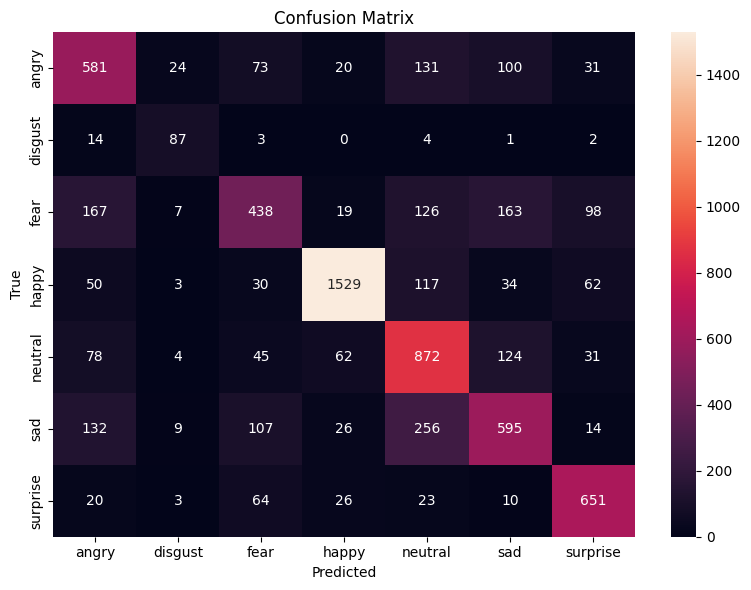

✓ Saved Confusion_matrix_FINAL_TRAINING.png successfully!


In [34]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()                 # avoids cutting edges
plt.savefig("Confusion_matrix_FINAL_TRAINING.png", dpi=300)   # save with high resolution
plt.show()
print("✓ Saved Confusion_matrix_FINAL_TRAINING.png successfully!")

# 🔟 Save model for real-time use (JSON + H5)

This keeps compatibility with existing realtimedetection.py structure:

In [15]:
# Save architecture
model_json = model.to_json()
with open("finalfacialemotionmodel.json", "w") as json_file:
    json_file.write(model_json)

# Save weights
model.save_weights("finalfacialemotionmodel.weights.h5")
print("Saved model to finalfacialemotionmodel.json + finalfacialemotionmodel.weights.h5")

# now copy these new files into the same folder where realtimedetection.py expects them.

Saved model to finalfacialemotionmodel.json + finalfacialemotionmodel.weights.h5


In [16]:
model.save("finalfacialemotionmodel.keras")

# 🧪 How to load it back later (JSON + weights style)

In [17]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("finalfacialemotionmodel.keras")

# Validation Of Model

In [18]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [19]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [20]:
def ef(image_path):
    # Load image as 48x48 grayscale
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    
    # Convert to array
    feature = img_to_array(img)           # shape: (48, 48, 1)
    
    # Normalize like during training
    feature = feature / 255.0
    
    # Add batch dimension: (1, 48, 48, 1)
    feature = feature.reshape(1, 48, 48, 1)
    
    return feature

In [21]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
model prediction is  sad


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
model prediction is  sad


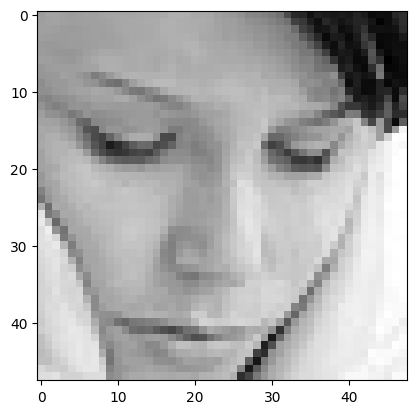

In [23]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
model prediction is  fear


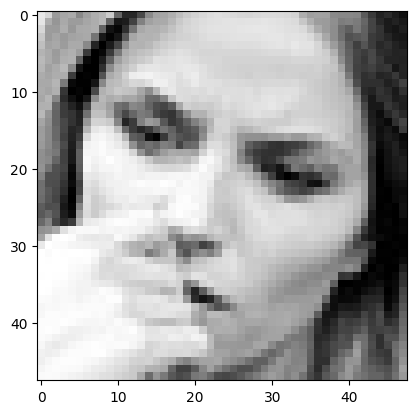

In [25]:
image = 'images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
model prediction is  disgust


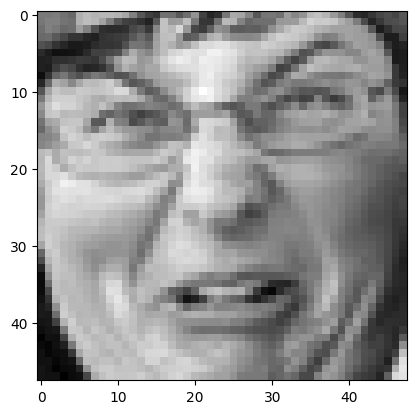

In [26]:
image = 'images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
model prediction is  happy


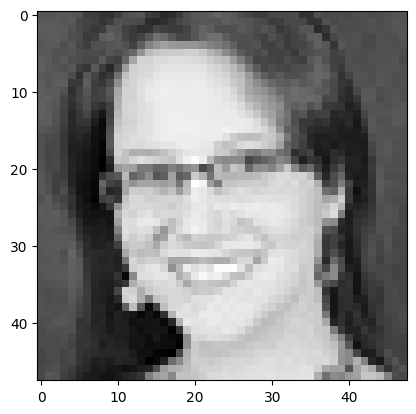

In [27]:
image = 'images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
model prediction is  surprise


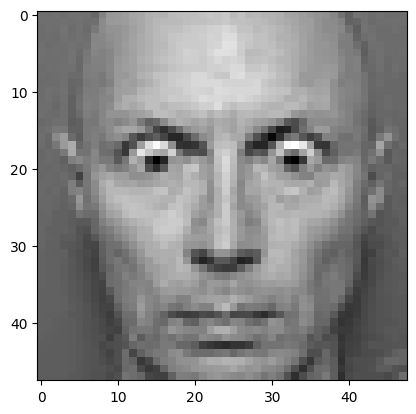

In [28]:
image = 'images/train/surprise/15.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

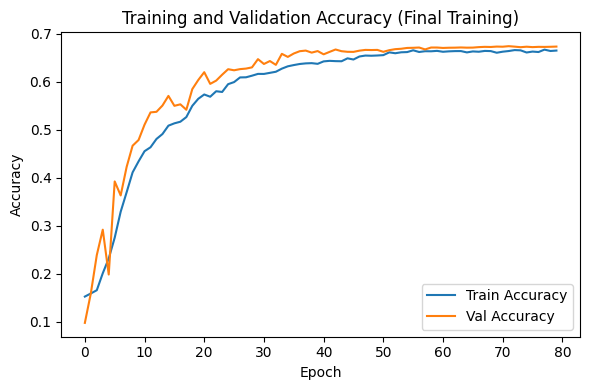

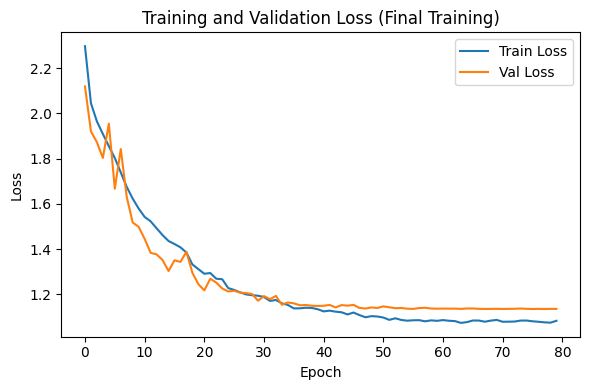

In [35]:
import matplotlib.pyplot as plt

# Accuracy curve
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (Final Training)")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve_final.png", dpi=300)
plt.show()

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Final Training)")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve_final.png", dpi=300)
plt.show()
